# U-Net model with attention and modified bottleneck

This notebook shows the basic U-net plus the attention block used for the segmentation task and consists of 4 blocks for the encoder and 4 blocks for the decoder. Each block has stack = 2 and consists of the sequence of layers: Convolution, Batch Normalisation and Activation.

The attention mechanism is inserted into each decoder block.

The bottleneck is composed by a squeeze and excitation block and a pyramid pooling block.

Residual block is integrated into the encoder.

Loss parameter are combined to find the best solution.

In [ ]:
from google.colab import drive
drive.mount("/gdrive")

%cd /gdrive/My Drive/Colab Notebooks/AN2DL/Consegna/Models

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/19rnOt7HHvCfH_okYCcOcZ369Xcv42CQy/Consegna/Models


In [ ]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [ ]:
seed = 42
import cv2

**Load dataset**

In [ ]:
data = np.load("mars_for_students_processed.npz")

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


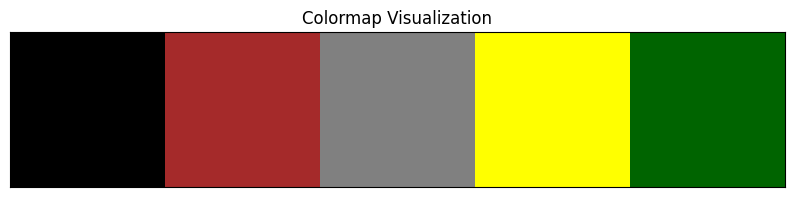

In [ ]:
from matplotlib.colors import ListedColormap

# Define colors for each class
class_colors = {
    0: "black",     # Background
    1: "brown",     # Soil
    2: "gray",      # Bedrock
    3: "yellow",    # Sand
    4: "darkgreen"  # Big Rock
}

cmap = ListedColormap([class_colors[key] for key in sorted(class_colors.keys())])

# Visualize colormap
plt.figure(figsize=(10, 10))
plt.imshow(np.arange(len(class_colors)).reshape((1, -1)), cmap=cmap)
plt.title("Colormap Visualization")
plt.xticks([])
plt.yticks([])
plt.show()

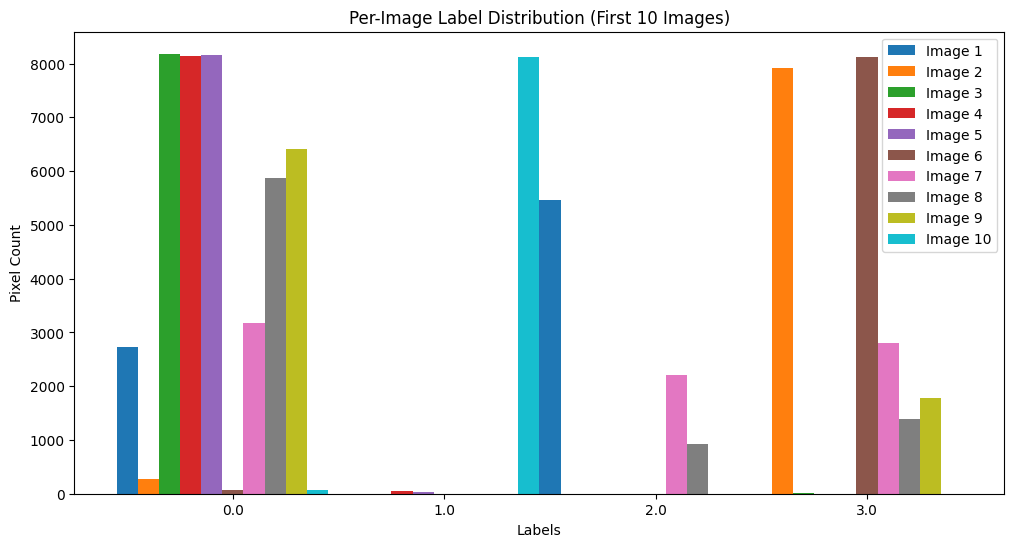

In [ ]:
# 1. Per-image label distribution for the first 10 images
label_counts_per_image = []
max_label = 0  # Track the highest label number for alignment

# Iterate over the first 10 label images
for label_img in y_train[:10]:  # Only first 10 images
    unique_labels, counts = np.unique(label_img, return_counts=True)
    label_count_dict = dict(zip(unique_labels, counts))
    label_counts_per_image.append(label_count_dict)
    max_label = max(max_label, max(unique_labels))

# Plotting per-image label distribution for the first 10 images
labels = np.arange(max_label + 1)  # Ensure we include all possible labels
bar_width = 0.1  # Width of each bar
positions = np.arange(len(labels))  # Base positions for bars
plt.figure(figsize=(12, 6))

# Plot bars for each image
for i, label_count in enumerate(label_counts_per_image):
    counts = [label_count.get(label, 0) for label in labels]  # Get counts for all labels
    plt.bar(positions + i * bar_width, counts, bar_width, label=f'Image {i+1}')
plt.xlabel('Labels')
plt.ylabel('Pixel Count')
plt.title('Per-Image Label Distribution (First 10 Images)')
plt.xticks(positions + bar_width * len(label_counts_per_image) / 2, labels)  # Align x-axis ticks
plt.legend()
plt.show()

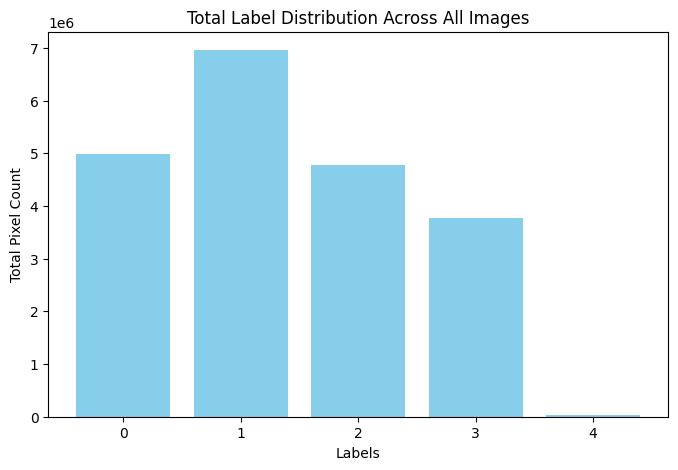

{0.0: 4988826, 2.0: 4776810, 3.0: 3770823, 1.0: 6957538, 4.0: 26963}


In [ ]:
# 2. Dataset-wide label distribution
label_counts_per_image = []
max_label = 0  # Track the highest label number for alignment
total_label_counts = {}

# Iterate over the first 10 label images
for label_img in y_train:  # Only first 10 images
    unique_labels, counts = np.unique(label_img, return_counts=True)
    label_count_dict = dict(zip(unique_labels, counts))
    label_counts_per_image.append(label_count_dict)
    max_label = max(max_label, max(unique_labels))

for label_count in label_counts_per_image:
    for label, count in label_count.items():
        total_label_counts[label] = total_label_counts.get(label, 0) + count

# Plotting total label distribution
plt.figure(figsize=(8, 5))
plt.bar(total_label_counts.keys(), total_label_counts.values(), color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Total Pixel Count')
plt.title('Total Label Distribution Across All Images')
plt.show()

print(total_label_counts)

In [ ]:
# Function to check how many images contain a specific label
def count_images_with_label(label, y_train):
    count = 0
    for label_img in y_train:
        if label in np.unique(label_img):  # Check if label exists in the image
            count += 1
    return count

# Example usage
label_to_check = 4  # Replace with your target label
count = count_images_with_label(label_to_check, y_train)

print(f"Number of images containing label {label_to_check}: {count}")

Number of images containing label 4: 63


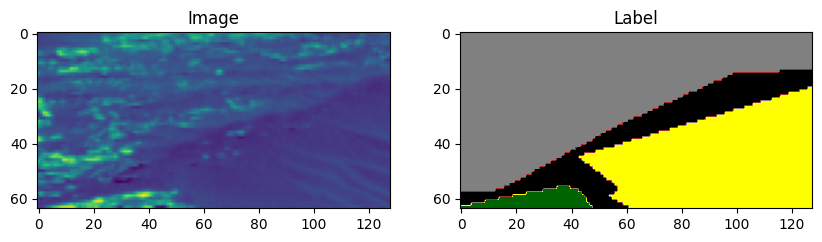

In [ ]:
# Visualize image with label 4
for i in range(len(y_train)):
    if 4 in np.unique(y_train[i]):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(X_train[i])
        plt.title("Image")
        plt.subplot(1, 2, 2)
        plt.imshow(y_train[i], cmap=cmap)
        plt.title("Label")
        plt.show()
        break

## Dataset creation
**Parameters**

In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

**Make dataset**

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    # If no seed is provided, generate one using TensorFlow
    if seed is None:
        seed = tf.random.uniform([], 0, 1000000, dtype=tf.int32)

    flip_prob = tf.random.uniform([], 0, 1, seed=seed)  # Random float between 0 and 1

    # Flip the image and label if the random probability is greater than 0.5
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )

    # Ensure label has 3 dimensions (height, width, 1)
    label = tf.expand_dims(label, axis=-1)
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )

    return image, tf.squeeze(label, axis=-1)

@tf.function
def random_brightness(image, max_delta=0.2):
    return tf.image.random_brightness(image, max_delta=max_delta)

@tf.function
def random_contrast(image, lower=0.7, upper=1.3):
    return tf.image.random_contrast(image, lower=lower, upper=upper)

@tf.function
def random_hue(image, max_delta=0.1):
    return tf.image.random_hue(image, max_delta=max_delta)

@tf.function
def random_zoom(image, label, zoom_range=(0.8, 1.2), seed=None):
    # If seed is not provided, generate a random two-element seed
    if seed is None:
        seed = tf.random.uniform([2], minval=0, maxval=1000000, dtype=tf.int32)
    # Generate a random zoom factor using the two-element seed
    zoom_factor = tf.random.stateless_uniform(
        shape=[], minval=zoom_range[0], maxval=zoom_range[1], seed=seed
    )
    # Get original dimensions
    original_size = tf.shape(image)[:2]  # [height, width]
    # Calculate crop size based on zoom factor
    crop_size = tf.cast(tf.cast(original_size, tf.float32) / zoom_factor, tf.int32)
    # Ensure label has 3 dimensions for consistent augmentation
    label = tf.expand_dims(label, axis=-1)
    # Center crop the image and label
    image = tf.image.resize_with_crop_or_pad(image, crop_size[0], crop_size[1])
    label = tf.image.resize_with_crop_or_pad(label, crop_size[0], crop_size[1])
    # Resize back to original size
    image = tf.image.resize(image, original_size, method=tf.image.ResizeMethod.BILINEAR)
    label = tf.image.resize(label, original_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # Squeeze label back to 2D if necessary
    label = tf.squeeze(label, axis=-1)

    return image, label

@tf.function
def random_crop(image, label, crop_size=(48, 96)):
    # Get the image and label dimensions
    image_height, image_width = tf.shape(image)[0], tf.shape(image)[1]
    crop_height, crop_width = crop_size

    # Randomly determine the starting coordinates for the crop
    start_y = tf.random.uniform([], minval=0, maxval=image_height - crop_height, dtype=tf.int32)
    start_x = tf.random.uniform([], minval=0, maxval=image_width - crop_width, dtype=tf.int32)

    # Perform the crop on both image and label
    cropped_image = tf.image.crop_to_bounding_box(image, start_y, start_x, crop_height, crop_width)
    cropped_label = tf.image.crop_to_bounding_box(label, start_y, start_x, crop_height, crop_width)

    return cropped_image, cropped_label

@tf.function
def focused_crop(image, label, crop_size=(48, 96), resize_to=(64, 128)):
    # Ensure label has 3 dimensions for consistent augmentation
    label = tf.expand_dims(label, axis=-1)

    # Identify the minority class region (non-zero pixels in the label)
    coords = tf.where(label > 0)  # Find pixels of the minority class
    if tf.size(coords) == 0:  # If minority class is absent, perform random crop
        cropped_image, cropped_label = random_crop(image, label, crop_size)
    else:
        # Compute the bounding box of the minority class
        y_min = tf.reduce_min(coords[:, 0])
        x_min = tf.reduce_min(coords[:, 1])
        y_max = tf.reduce_max(coords[:, 0])
        x_max = tf.reduce_max(coords[:, 1])

        # Compute the center of the minority-class region
        center_y = (y_min + y_max) // 2
        center_x = (x_min + x_max) // 2

        # Determine crop coordinates
        crop_height, crop_width = crop_size
        start_y = tf.clip_by_value(center_y - crop_height // 2, 0, tf.shape(image)[0] - crop_height)
        start_x = tf.clip_by_value(center_x - crop_width // 2, 0, tf.shape(image)[1] - crop_width)

        # Perform cropping
        cropped_image = tf.image.crop_to_bounding_box(image, start_y, start_x, crop_height, crop_width)
        cropped_label = tf.image.crop_to_bounding_box(label, start_y, start_x, crop_height, crop_width)

    # Resize to the specified dimensions
    resized_image = tf.image.resize(cropped_image, resize_to, method=tf.image.ResizeMethod.BILINEAR)
    resized_label = tf.image.resize(cropped_label, resize_to, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Squeeze label back to 2D if necessary
    resized_label = tf.squeeze(resized_label, axis=-1)

    return resized_image, resized_label

@tf.function
def apply_augmentations(image, label, seed=None):
    image, label = random_flip(image, label, seed)
    image = random_brightness(image, max_delta=0.3)
    image = random_contrast(image, lower=0.0, upper=0.5)
    image = random_hue(image, max_delta=0.3)
    image, label = focused_crop(image, label, crop_size=(48, 96))
    image, label = random_zoom(image, label, zoom_range=(0.0, 0.2))

    return image, label

In [ ]:
def make_dataset(X_in, y_in, batch_size, shuffle=True, augment=False, seed=None):
    # Create a tf.data.Dataset from X_train and y_train
    dataset = tf.data.Dataset.from_tensor_slices((X_in, y_in))

    # Shuffle the dataset if shuffle is True
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply preprocessing
    dataset = dataset.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply data augmentation
    if augment:
        dataset = dataset.map(
            lambda x, y: apply_augmentations(x, y, seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)

    # Prefetch for better performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
def make_test_dataset(X_test, batch_size, shuffle=False, seed=None):
    # Create a tf.data.Dataset from X_test
    dataset = tf.data.Dataset.from_tensor_slices(X_test)

    # Shuffle the dataset if shuffle is True (not necessary for testing, but optional)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply preprocessing
    dataset = dataset.map(
        lambda x: tf.cast(x, tf.float32) / 255.0,  # Normalize image to [0, 1]
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)

    # Prefetch for better performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

**Split train and validation set**

In [ ]:
from sklearn.model_selection import train_test_split

# Calculate the dominant class for each image
def calculate_dominant_label(masks):
    dominant_labels = []

    for mask in masks:
        unique_labels, counts = np.unique(mask, return_counts=True)
        dominant_labels.append(unique_labels[np.argmax(counts)])  # Append the most frequent label

    return np.array(dominant_labels)

# Apply the function to compute labels for stratification
dominant_labels = calculate_dominant_label(y_train)

# Split the dataset while ensuring stratification by dominant labels
train_img, val_img, train_lbl, val_lbl = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=seed,
    stratify=dominant_labels  # Stratify by dominant label
)

print(f"Train images: {len(train_img)}, Validation images: {len(val_img)}")

# Print shape
print(f"Train images shape: {train_img.shape}")
print(f"Train labels shape: {train_lbl.shape}")
print(f"Validation images shape: {val_img.shape}")

count = count_images_with_label(label_to_check, train_lbl)
print(f"Number of images containing label {label_to_check}: {count}")

Train images: 2004, Validation images: 501
Train images shape: (2004, 64, 128, 1)
Train labels shape: (2004, 64, 128)
Validation images shape: (501, 64, 128, 1)
Number of images containing label 4: 49


In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=False,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_test_dataset(
    X_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print("Datasets created.")
# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created.

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128)
Labels dtype: <dtype: 'int32'>


## U-Net model definiton
**Block creation**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, Add, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Multiply, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, MaxPool2D

def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, dilation_rate=1, batch=1, name=''):
    x = input_tensor
    for i in range(stack):
        x = layers.Conv2D(filters, kernel_size=kernel_size, padding='same', dilation_rate=dilation_rate, name=name + 'conv' + str(i + 1))(x)
        if batch == 1:
          x = layers.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        else:
          x = layers.GroupNormalization(name=name + 'gn' + str(i + 1))(x)
        x = layers.Activation(activation, name=name + 'activation' + str(i + 1))(x)
    return x



# Squeeze-and-Excitation block
def squeeze_excite_block(input, ratio=16):
    channels = input.shape[-1]
    se = GlobalAveragePooling2D()(input)
    se = layers.Reshape((1, 1, channels))(se)
    se = Conv2D(channels // ratio, (1, 1), activation='relu', padding='same')(se)
    se = Conv2D(channels, (1, 1), activation='sigmoid', padding='same')(se)
    return Multiply()([input, se])

def attention_up(s, up_sampl, num_filters, name=''):
    Wg = layers.Conv2D(num_filters, 1, padding="same")(up_sampl)
    Wg = layers.BatchNormalization()(Wg)

    Ws = layers.Conv2D(num_filters, 1, padding="same")(s)
    Ws = layers.BatchNormalization()(Ws)

    out = layers.Activation("relu")(Wg + Ws)
    out = layers.Conv2D(num_filters, 1, padding="same")(out)
    out = layers.Activation("sigmoid")(out)

    return out * s

def batchnorm_relu(inputs):
    """ Batch Normalization & ReLU """
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)

    return x

def residual_block(inputs, num_filters, strides=1, name=''):
    """ Convolutional Layers """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)

    """ Shortcut Connection (Identity Mapping) """
    s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    """ Addition """
    x = x + s

    return x

**Observations**:

The Squeeze-and-Excitation block is a mechanism designed to enhance the representational power of a neural network by recalibrating the channel-wise features of the input tensor.

The residual block is designed to address the vanishing gradient problem by incorporating a shortcut (identity mapping) that allows gradients to flow directly through the network during backpropagation.

In [ ]:
def calculate_receptive_field(model):
    layers = [layer for layer in model.layers if hasattr(layer, 'kernel_size')]

    # Initialize variables
    receptive_field = 1
    stride = 1
    for layer in reversed(layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            kernel_size = layer.kernel_size[0]  # Assuming square kernels
            dilation_rate = layer.dilation_rate[0]
            receptive_field = receptive_field + (kernel_size - 1) * dilation_rate
        elif isinstance(layer, tf.keras.layers.MaxPooling2D):
            pool_size = layer.pool_size[0]
            stride *= pool_size
            receptive_field *= stride
        elif isinstance(layer, tf.keras.layers.UpSampling2D):
            stride /= layer.size[0]
            receptive_field /= stride

    return receptive_field

def pyramid_pooling_block(input_tensor, pool_sizes=[1, 2, 3, 6]):
    """
    Pyramid Pooling Block that applies multiple pool sizes and concatenates the results.
    Args:
        input_tensor (tf.Tensor): Input tensor to the block (feature map from bottleneck).
        pool_sizes (list): List of pool sizes for pyramid pooling.

    Returns:
        tf.Tensor: Tensor after pyramid pooling.
    """
    pool_layers = []
    h, w, c = input_tensor.shape[1:]  # Assuming NHWC format (batch, height, width, channels)

    for pool_size in pool_sizes:
        # Apply pooling layer with each pool size
        pool = tfkl.AveragePooling2D(pool_size=(pool_size, pool_size), strides=(1, 1), padding='same')(input_tensor)
        pool = tfkl.Lambda(lambda x: tf.image.resize(x, (h, w)))(pool)  # Upsample back to original size
        pool_layers.append(pool)

    # Concatenate the pooled features along the channels axis
    pooled_features = tfkl.Concatenate(axis=-1)(pool_layers)

    return pooled_features

**Observation**:
The Pyramid Pooling Block is a module designed to capture multi-scale contextual information from the input feature map by applying pooling operations at different scales.

Receptive field is creating to visualize how many pixel are investigated by the network.

**U-Net**

In [ ]:
def model(input_shape=input_shape, num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_tensor=input_layer , filters=64, kernel_size=3, activation='relu', stack=2, dilation_rate=1, batch=1, name='down_block1_')
    d1_res = residual_block(inputs= down_block_1, num_filters=64, strides=1, name='down_block_res1_')
    d1 = tfkl.MaxPooling2D((2,2))(d1_res)
    d1 = tfkl.Dropout(0.2, seed=seed)(d1)

    down_block_2 = unet_block(input_tensor=d1 , filters=128, kernel_size=3, activation='relu', stack=2, dilation_rate=1, batch=1, name='down_block2_')
    d2_res = residual_block(inputs= down_block_2, num_filters=128, strides=1, name='down_block_res2_')
    d2 = tfkl.MaxPooling2D((2,2))(d2_res)
    d2 = tfkl.Dropout(0.2, seed=seed)(d2)

    down_block_3 = unet_block(input_tensor=d2 , filters=256, kernel_size=3, activation='relu', stack=2, dilation_rate=1, batch=1, name='down_block3_')
    d3_res = residual_block(inputs= down_block_3, num_filters=256, strides=1, name='down_block_res3_')
    d3 = tfkl.MaxPooling2D((2,2))(d3_res)
    d3 = tfkl.Dropout(0.2, seed=seed)(d3)

    down_block_4 = unet_block(input_tensor=d3 , filters=512, kernel_size=3, activation='relu', stack=2, dilation_rate=1, batch=1, name='down_block4_')
    d4_res = residual_block(inputs= down_block_4, num_filters=512, strides=1, name='down_block_res4_')
    d4 = tfkl.MaxPooling2D((2,2))(d4_res)
    d4 = tfkl.Dropout(0.2, seed=seed)(d4)

    # Bottleneck
    bottleneck = squeeze_excite_block(d4, ratio=16)
    bottleneck = pyramid_pooling_block(bottleneck, pool_sizes=[1, 2, 4, 8])
    bottleneck = unet_block(bottleneck, 512, name='bottleneck')

    # Upsampling path
    u4 = tfkl.UpSampling2D(interpolation="bilinear")(bottleneck)
    u4 = tfkl.Dropout(0.2, seed=seed)(u4)
    u4_att = attention_up(s=d4_res, up_sampl=u4,  num_filters=512, name='attention1_')
    u4 = tfkl.Concatenate()([u4, u4_att])
    u4 = unet_block(input_tensor=u4 , filters=512, kernel_size=3, activation='relu', stack=2, dilation_rate=1, batch=1, name='up_block1_')

    u3 = tfkl.UpSampling2D(interpolation="bilinear")(u4)
    u3 = tfkl.Dropout(0.2, seed=seed)(u3)
    u3_att = attention_up(s=d3_res, up_sampl=u3, num_filters=256, name='attention2_')
    u3 = tfkl.Concatenate()([u3, u3_att])
    u3 = unet_block(input_tensor=u3 , filters=256, kernel_size=3, activation='relu', stack=2, dilation_rate=1, batch=1, name='up_block2_')

    u2 = tfkl.UpSampling2D(interpolation="bilinear")(u3)
    u2 = tfkl.Dropout(0.2, seed=seed)(u2)
    u2_att = attention_up(s=d2_res, up_sampl=u2, num_filters=128, name='attention3_')
    u2 = tfkl.Concatenate()([u2, u2_att])
    u2 = unet_block(input_tensor=u2, filters=128, kernel_size=3, activation='relu', stack=2, dilation_rate=1, batch=1, name='up_block3_')

    u1 = tfkl.UpSampling2D(interpolation="bilinear")(u2)
    u1 = tfkl.Dropout(0.2, seed=seed)(u1)
    u1_att = attention_up(s=d1_res, up_sampl=u1, num_filters=64, name='attention4_')
    u1 = tfkl.Concatenate()([u1, u1_att])
    u1 = unet_block(input_tensor=u1 , filters=64, kernel_size=3, activation='relu', stack=2, dilation_rate=1, batch=1, name='up_block4_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u1)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output_layer, name='UNet')

    return model

In [ ]:
model = model(input_shape=input_shape, num_classes=num_classes, seed=seed)

# Calculate receptive field
rf = calculate_receptive_field(model)
print(f"Receptive field of the model: {rf}")


# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary()
model.save('model.h5')

Receptive field of the model: 53


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_conv1         │ (None, 64, 128, 64)    │            640 │ input_layer[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_bn1           │ (None, 64, 128, 64)    │            256 │ down_block1_conv1[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_activation1   │ (None, 64, 128, 64)    │              0 │ down_block1_bn1[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_conv2         │ (None, 64, 128, 64)    │         36,928 │ down_block1_activatio… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_bn2           │ (None, 64, 128, 64)    │            256 │ down_block1_conv2[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_activation2   │ (None, 64, 128, 64)    │              0 │ down_block1_bn2[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 128, 64)    │            256 │ down_block1_activatio… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 64, 128, 64)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 128, 64)    │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 128, 64)    │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 64, 128, 64)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 128, 64)    │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 128, 64)    │          4,160 │ down_block1_activatio… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 128, 64)    │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_2[0][0]         │
├──────────────────────

 Total params: 34,477,861 (131.52 MB)

 Trainable params: 34,460,453 (131.46 MB)

 Non-trainable params: 17,408 (68.00 KB)

**Callbacks**

In [ ]:
# Setup callbacks
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou',
    mode = 'max',
    factor=0.1,
    patience=10,
    min_delta=1e-5,
    verbose=1,
    min_lr=1e-6
)

**Loss function**

In [ ]:
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False, name='mean_iou')

def tversky_loss(y_true, y_pred, alpha=0.5, beta=0.5, smooth=1e-6):
    """
    Tversky loss function for image segmentation.

    Arguments:
    - y_true: Ground truth labels (batch_size, height, width, num_classes).
    - y_pred: Model predictions (batch_size, height, width, num_classes).
    - alpha: Weight for false positives.
    - beta: Weight for false negatives.
    - smooth: Smoothing factor to avoid division by zero.

    Returns:
    - Tversky loss value.
    """
    # Convert labels to one-hot if not already
    if y_true.shape[-1] != y_pred.shape[-1]:
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, depth=y_pred.shape[-1])

    # Flatten the tensors
    y_true_f = tf.reshape(y_true, [-1, y_pred.shape[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, y_pred.shape[-1]])

    # Calculate true positives (TP), false positives (FP), and false negatives (FN)
    tp = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    fp = tf.reduce_sum((1 - y_true_f) * y_pred_f, axis=0)
    fn = tf.reduce_sum(y_true_f * (1 - y_pred_f), axis=0)

    # Compute Tversky index
    tversky_index = (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)

    # Tversky loss
    tversky_loss = 1 - tf.reduce_mean(tversky_index)

    return tversky_loss

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        # Convert labels to one-hot if not already
        if y_true.shape[-1] != y_pred.shape[-1]:
            y_true = tf.cast(y_true, tf.int32)
            y_true = tf.one_hot(y_true, depth=y_pred.shape[-1])

        # Flatten the images
        y_true_f = tf.reshape(y_true, (-1, y_pred.shape[-1]))
        y_pred_f = tf.reshape(y_pred, (-1, y_pred.shape[-1]))
        y_pred_f = tf.clip_by_value(y_pred_f, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())

        cross_entropy = -y_true_f * tf.math.log(y_pred_f)

        weights = alpha * tf.math.pow(1 - y_pred_f, gamma)

        return tf.reduce_sum(weights * cross_entropy, axis=-1)

    return loss

def combined_loss(y_true, y_pred, dice_weight=0.5, focal_weight=0.5, tversky_weight=0.5):
    """
    Combined loss function: a weighted sum of Dice loss and Focal loss.

    Arguments:
    - y_true: Ground truth labels (batch_size, height, width, num_classes or sparse labels).
    - y_pred: Predicted outputs from the model (batch_size, height, width, num_classes).
    - dice_weight: Weight for the Dice loss component.
    - focal_weight: Weight for the Focal loss component.
    """
    # Calculate individual losses
    dice = dice_loss(y_true, y_pred)
    focal = focal_loss(gamma=3)(y_true, y_pred)
    focal_loss_w = weighted_focal_loss(weights=weights, gamma=2.0)(y_true, y_pred)
    tversky = tversky_loss(y_true, y_pred, 0.5, 0.5)

    # Combine the losses with respective weights
    return focal_weight * focal + tversky_weight * tversky

# Model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, focal_weight=0.7, tversky_weight= 0.3),
    metrics=['accuracy', mean_iou]
)

Pesi delle classi: tf.Tensor([  0.8315864   0.5883903   0.8581766   1.0787759 175.7778   ], shape=(5,), dtype=float32)


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_plateau]
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)

print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.3670 - loss: 0.3535 - mean_iou: 0.1571 - val_accuracy: 0.2535 - val_loss: 2.3737 - val_mean_iou: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 883ms/step - accuracy: 0.4920 - loss: 0.2954 - mean_iou: 0.2305 - val_accuracy: 0.2535 - val_loss: 2.3780 - val_mean_iou: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 874ms/step - accuracy: 0.5195 - loss: 0.2905 - mean_iou: 0.2481 - val_accuracy: 0.2535 - val_loss: 2.3566 - val_mean_iou: 5.5001e-07 - learning_rate: 0.0010
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 875ms/step - accuracy: 0.5817 - loss: 0.2724 - mean_iou: 0.2942 - val_accuracy: 0.2535 - val_loss: 2.2692 - val_mean_iou: 7.9644e-06 - learning_rate: 0.0010
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 900ms/step - accuracy: 0.6150 - loss: 0.2585 - mean_iou: 0.3223 - val_accuracy: 0.1772 - val_loss: 1.9428 - val_mean_iou: 0.0593 - learning_rate: 0.0010
E

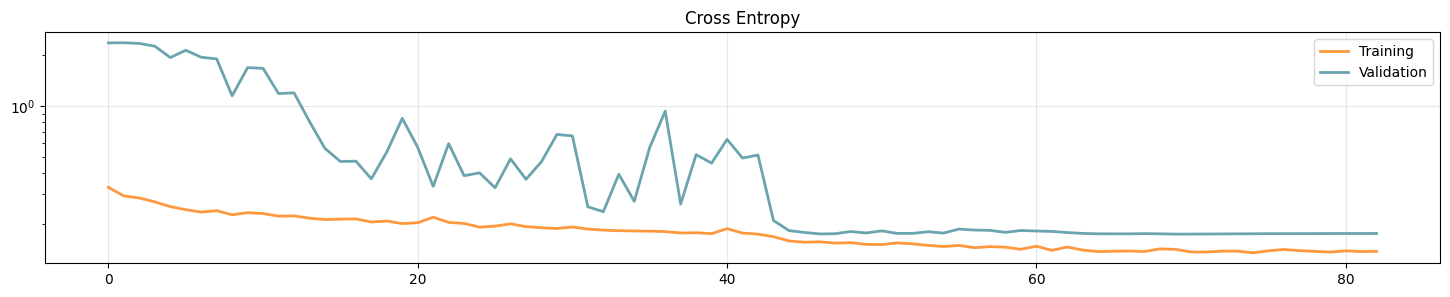

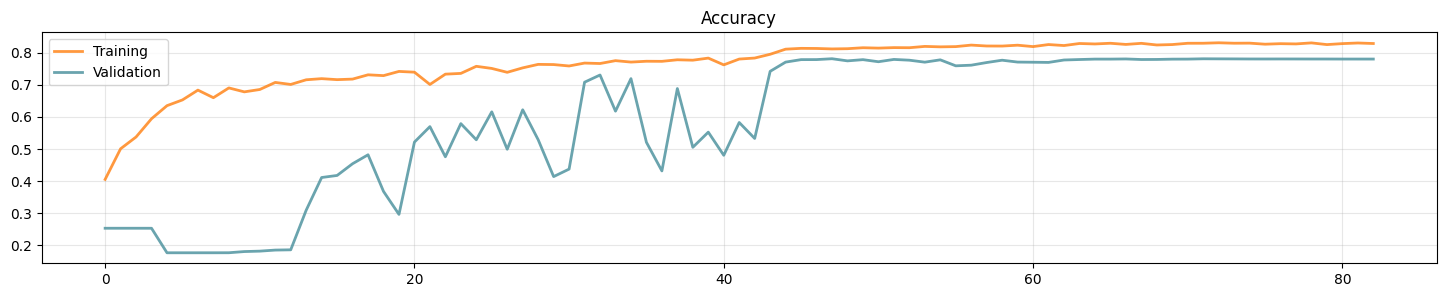

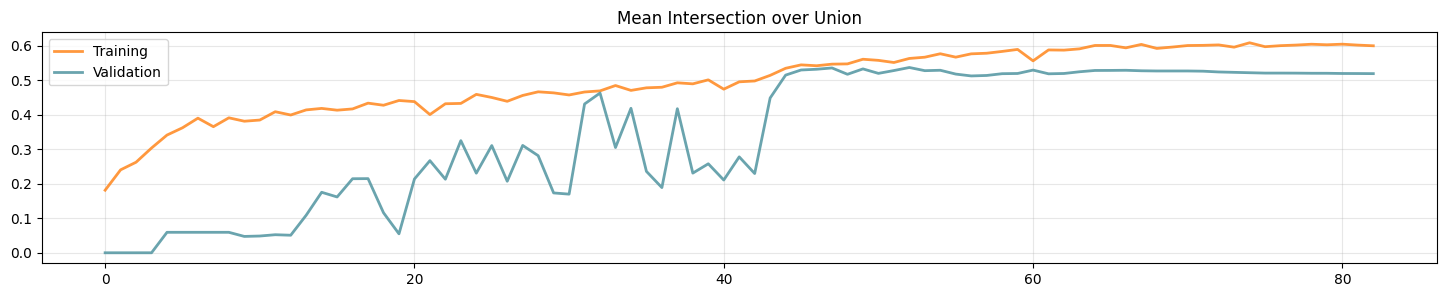

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Visualize prediction validation set

In [ ]:
y_val_pred = model.predict(val_dataset)
y_val_pred = np.argmax(y_val_pred, axis=-1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 749ms/step


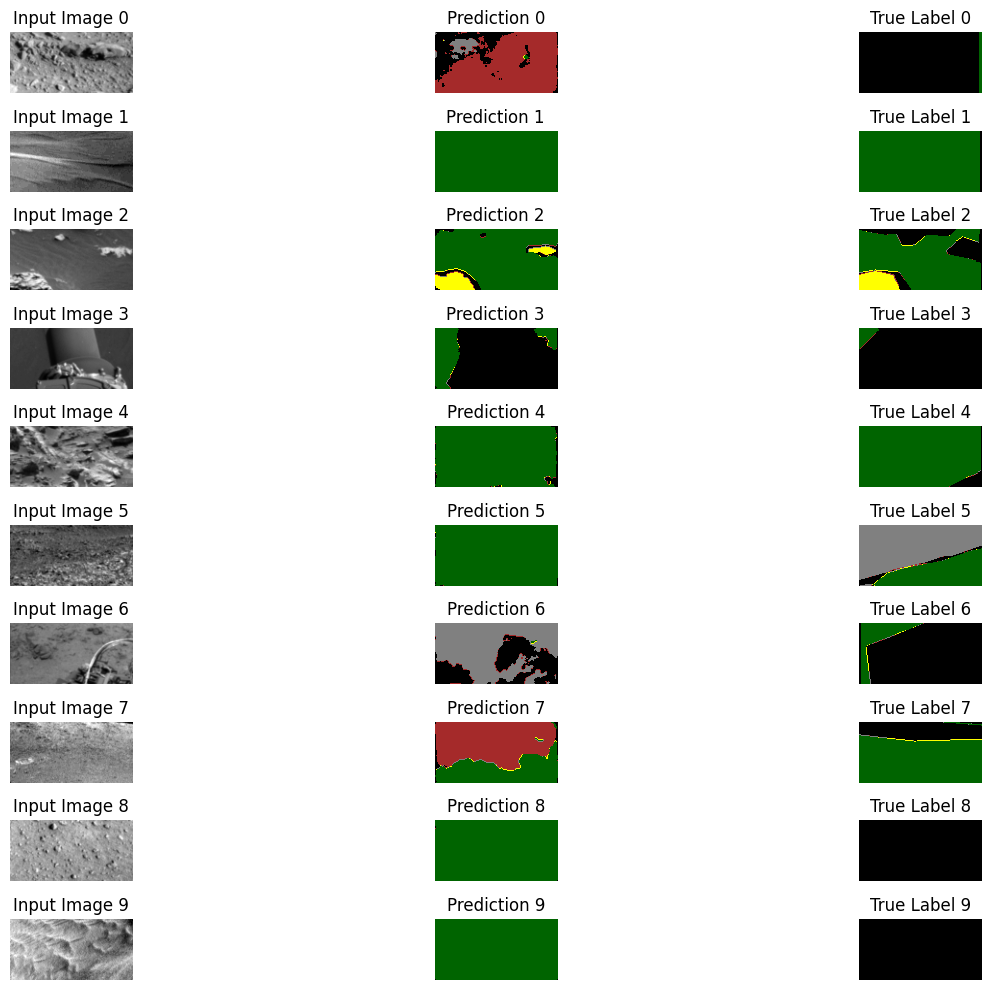

In [ ]:
def display_images_with_predictions_and_true_labels(input_images, predictions, true_labels, start=0, end=5, figsize=(15, 10)):
    # Set up the figure for displaying images
    fig, axes = plt.subplots(end - start, 3, figsize=figsize)
    for i in range(start, end):
        # Display the input image
        axes[i-start, 0].imshow(input_images[i, :, :, 0], cmap='gray')
        axes[i-start, 0].set_title(f'Input Image {i}')
        axes[i-start, 0].axis('off')

        # Display the predicted mask
        axes[i-start, 1].imshow(predictions[i, :, :], cmap=cmap)  # Use a color map for prediction
        axes[i-start, 1].set_title(f'Prediction {i}')
        axes[i-start, 1].axis('off')

        # Display the true mask
        axes[i-start, 2].imshow(true_labels[i, :, :], cmap=cmap)  # Use the same color map for ground truth
        axes[i-start, 2].set_title(f'True Label {i}')
        axes[i-start, 2].axis('off')

    plt.tight_layout()
    plt.show()

display_images_with_predictions_and_true_labels(val_img, y_val_pred, val_lbl, start=0, end=10)

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def compute_metrics(y_true, y_pred, num_classes=5):
    # Flatten the arrays for metric calculation
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Precision and Recall for each class
    precision = precision_score(y_true_flat, y_pred_flat, average=None, labels=np.arange(num_classes))
    recall = recall_score(y_true_flat, y_pred_flat, average=None, labels=np.arange(num_classes))

    # Overall Accuracy
    accuracy = accuracy_score(y_true_flat, y_pred_flat)

    return precision, recall, accuracy

# Compute metrics
precision, recall, accuracy = compute_metrics(val_lbl, y_val_pred, num_classes=5)

# Print results
print(f"Precision (per class): {precision}")
print(f"Recall (per class): {recall}")
print(f"Overall Accuracy: {accuracy}")

Precision (per class): [0.70866935 0.84748478 0.73002879 0.78769658 0.29777186]
Recall (per class): [0.51475265 0.85351922 0.87135653 0.88611872 0.29683728]
Overall Accuracy: 0.7764178673902196


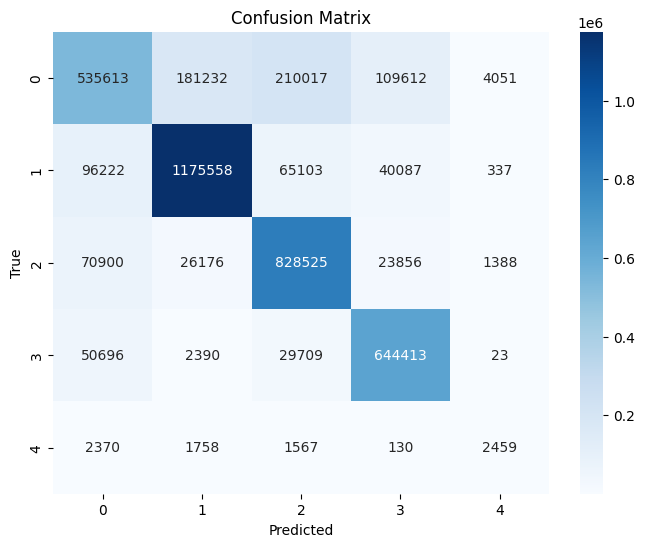

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, num_classes=num_classes):
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten(), labels=np.arange(num_classes))

    # Plot confusion matrix using Seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(val_lbl, y_val_pred)

In [ ]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
# del model

print(f"Model saved to {model_filename}")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, focal_weight=0.7, tversky_weight= 0.3),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


Model saved to model_241214_003553.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.

In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)

    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

    model = tfk.models.load_model(model_filename)

    print(f"Model loaded from {model_filename}")

In [ ]:
preds = model.predict(test_dataset)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 64s 390ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""

    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]

    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file saved to {submission_filename}")
from google.colab import files
files.download(submission_filename)

# output_path = '/kaggle/working/'
# os.rename(submission_filename, os.path.join(output_path, submission_filename))
# print(f"Submission file moved to {output_path}{submission_filename}")

Submission file saved to submission_241214_003553.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>